In [1]:
import torch
import torchmetrics
import torchvision

from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
from torchvision import datasets, transforms
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
pl.seed_everything(42)

Global seed set to 42


42

As usual, our first step is to create the DataModule. We will re-use the same datamodule that we had used for the classification problem. 

In [3]:
%run 14-common-mnist-data-module.ipynb

We will implement 2 encoder-decoder setups
1. A convolution layer based encoder-decoder
2. A simple linear layer based encoder-decoder

In [4]:
class ConvEncoder(nn.Module):
    def __init__(self, nz, img_shape):
        super(ConvEncoder, self).__init__()
        self.nz = nz
        in_channels, h, w = img_shape
        
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1), #(batch_size, 32, h, w)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2), #(batch_size, 32, h/2, w/2)
            nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1), #(batch_size, 128, h/2, w/2)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),  #(batch_size, 128, h/4, w/4)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), #(batch_size, 256, h/4, w/4)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #(batch_size, 256, h/8, w/8)
            nn.Flatten()
        ) 
        conv_out_size = 256 * int(h / 8) ** 2
        
        # The parameters mu and log variance
        self.mu = torch.nn.Linear(conv_out_size, nz)
        self.log_var = torch.nn.Linear(conv_out_size, nz)
        
    def forward(self, x):
        """
        Input:  X -> (batch_size, c, h, w) tensor 
        Output: mu -> (batch_size, nz) tensor
               log_var -> (batch_size, nz) tensor
        """
        conv_out = self.conv_encoder(X)
        mu = self.mu(conv_out)
        log_var = self.log_var(conv_out)
        return mu, log_var

    
class ConvDecoder(nn.Module):
    def __init__(self, nz, img_shape):
        super(ConvDecoder, self).__init__()
        self.nz = nz
        in_channels, h, w = img_shape
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.nz, out_channels=256, kernel_size=4, 
                               stride=1, padding=0, bias=False), #(batch_size, 256, h/8, w/8)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, 
                               stride=2, padding=0, bias=False), #(batch_size, 128, h/4, w/4)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 32, kernel_size=2, 
                               stride=2, padding=0, bias=False), #(batch_size, 32, h/2, w/2)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, in_channels, kernel_size=2, 
                               stride=2, padding=0, bias=False), #(batch_size, 3, h, w)
            nn.Sigmoid(),
        )
        
    def forward(self, z):
        """
        This method is responsible for decoding. 
        Input:   z -> (batch_size, nz) tensor
        Output: Xr -> (batch_size, c, h, w) tensor i.e the reconstructed image
        """
        # The input is a (batch_size, nz) tensor. We convert it into (batch_size, nz, 1, 1) tensor.
        Xr = self.decoder(z.view(z.shape[0], z.shape[1], 1, 1))
        return Xr

In [5]:
class LinearEncoder(nn.Module):
    def __init__(self, nz, img_shape):
        super(LinearEncoder, self).__init__()
        self.nz = nz
        in_channels, h, w = img_shape
        self.base_encoder = torch.nn.Sequential(
            torch.nn.Flatten(), # Flatten the image tensor from (batch_size, c, h, w) to (batch_size, c*h*w)
            torch.nn.Linear(in_channels*h*w , 512), # (batch_size, 512)
            torch.nn.ReLU(True),
        )
        
        # The parameters mu and log variance
        self.mu = torch.nn.Linear(512, nz)
        self.log_var = torch.nn.Linear(512, nz)
        
    def forward(self, X):
        """
        Input:  X -> (batch_size, c, h, w) tensor 
        Output: mu -> (batch_size, nz) tensor
               log_var -> (batch_size, nz) tensor
        """
        encoder_out = self.base_encoder(X)
        mu = self.mu(encoder_out)
        log_var = self.log_var(encoder_out)
        return mu, log_var
    
class LinearDecoder(nn.Module):
    def __init__(self, nz, img_shape):
        super(LinearDecoder, self).__init__()
        self.nz = nz
        self.img_shape = img_shape
        in_channels, h, w = img_shape
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(nz, 512),
            torch.nn.ReLU(True),
            torch.nn.Linear(512, in_channels*h*w),
            torch.nn.Sigmoid(),
        )
        
    def forward(self, z):
        """
        This method is responsible for decoding. 
        Input:   z -> (batch_size, nz) tensor
        Output: Xr -> (batch_size, c, h, w) tensor i.e the reconstructed image
        """
        Xr = self.decoder(z).reshape(-1, self.img_shape[0], self.img_shape[1], self.img_shape[2])
        return Xr

In [6]:
class VariationalAutoEncoder(LightningModule):
    def __init__(self, nz, backbone="linear", beta=1.0, img_shape=(1, 32, 32)):
        super(VariationalAutoEncoder, self).__init__()
        self.save_hyperparameters()
        
        self.nz = nz
        self.img_shape = img_shape
        
        assert backbone in ["linear", "conv"], f"{backbone} must be one of linear/conv"
        
        if backbone == "linear":
            self.encoder = LinearEncoder(nz, img_shape)
            self.decoder = LinearDecoder(nz, img_shape)
        else:
            self.encoder = ConvEncoder(nz, img_shape)
            self.decoder = ConvDecoder(nz, img_shape)
        
        self.beta = beta
   
    
    def sample(self, mu, log_var):
        """
        We use the reparameterization trick to sample from a Normal Distribution
        with parameters mu and log_var
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def core_step(self, X):
        mu, log_var = self.encoder(X)
        z = self.sample(mu, log_var)
        Xr = self.decoder(z)
        
        # Reconstruction loss
        # VAEs typically work better with binary cross entropy instead of 
        # Mean squared error.
        recon_loss = F.binary_cross_entropy(Xr, X, reduction="sum")
        
        # KL Divergence loss
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        total_loss = recon_loss + self.beta * kld_loss
        return {
            "recon_loss": recon_loss,
            "kld_loss": kld_loss,
            "total_loss": total_loss
        }
    
    def training_step(self, batch, batch_idx):
        """
        This method implements the basic training step. We will run forward pass, compute 
        loss. We will log any necessary values, and return the total loss.
        """
        X, _ = batch # We don't care about the target for unsupervised learning
        loss_dict = self.core_step(X)
        if self.global_step % 100 == 0:
            for k, v in loss_dict.items():
                self.log(f"train/{k}", v, on_step=True, on_epoch=True)
        return loss_dict["total_loss"]
    
    def validation_step(self, batch, batch_idx, dataset_idx=None):
        """
        This method implements the basic validation step. We will run the forward pass, compute the loss
        and return it.
        """
        X, _ = batch
        return self.core_step(X)
    
    def validation_epoch_end(self, outputs):
        """
        This method will be called at the end of all test steps for each epoch i.e the validation epoch end.
        The output of every single test_step is available to via outputs. 
        
        """
        
        avg_recon_loss = torch.tensor([x["recon_loss"] for x in outputs]).mean()
        avg_kld_loss = torch.tensor([x["kld_loss"] for x in outputs]).mean()
        avg_loss = torch.tensor([x["total_loss"] for x in outputs]).mean()
        self.log("val/recon_loss", avg_recon_loss)
        self.log("val/kld_loss", avg_kld_loss)
        self.log("val/total_loss", avg_loss)
        print(f"Epoch {self.current_epoch}, Val: Reconstruction loss: {avg_recon_loss:0.2f} KLD loss: {avg_kld_loss:0.2f} Total loss: {avg_loss:0.2f}")
        return avg_loss
    
        
    def configure_optimizers(self):
        """
        The optimizer will be configured in this method
        """
        return torch.optim.Adam(model.parameters())
    
    def checkpoint_callback(self):
        """
        This callback determines the logic for how we want to checkpoint / save the model
        """
        # We will save the model with the lowest val loss.
        return ModelCheckpoint(monitor="val/total_loss", mode="min", save_top_k=1)

In [7]:
dm = MNISTDataModule()
# We will use a simple setup in order to train fast. The reader is encouraged to play around
# with different parameters.
nz = 2
model = VariationalAutoEncoder(nz=nz, backbone="linear", beta=1.0, img_shape=(1, 32, 32))

In [8]:
exp_dir = "/tmp/mnist_vae/"
checkpoint_callback = model.checkpoint_callback()
 
trainer = Trainer(
        default_root_dir=exp_dir, # The experiment directory
        callbacks=[checkpoint_callback],
        gpus=torch.cuda.device_count(), # Number of GPUs to run on
        max_epochs=20,
        num_sanity_val_steps=0
    )
trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type          | Params
------------------------------------------
0 | encoder | LinearEncoder | 526 K 
1 | decoder | LinearDecoder | 526 K 
------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.215     Total estimated model params size (MB)
/Users/ananya.h.a/.virtualenvs/dl_book/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/ananya.h.a/.virtualenvs/dl_book/lib/python3.7/site-packages/pytorch_lightning/trainer/data_lo

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, Val: Reconstruction loss: 22254.11 KLD loss: 554.29 Total loss: 22808.40


Validating: 0it [00:00, ?it/s]

Epoch 1, Val: Reconstruction loss: 21606.55 KLD loss: 542.34 Total loss: 22148.89


Validating: 0it [00:00, ?it/s]

Epoch 2, Val: Reconstruction loss: 21260.69 KLD loss: 579.07 Total loss: 21839.76


Validating: 0it [00:00, ?it/s]

Epoch 3, Val: Reconstruction loss: 21033.64 KLD loss: 569.82 Total loss: 21603.46


Validating: 0it [00:00, ?it/s]

Epoch 4, Val: Reconstruction loss: 20814.08 KLD loss: 609.23 Total loss: 21423.31


Validating: 0it [00:00, ?it/s]

Epoch 5, Val: Reconstruction loss: 20762.10 KLD loss: 581.57 Total loss: 21343.67


Validating: 0it [00:00, ?it/s]

Epoch 6, Val: Reconstruction loss: 20603.17 KLD loss: 612.63 Total loss: 21215.80


Validating: 0it [00:00, ?it/s]

Epoch 7, Val: Reconstruction loss: 20529.57 KLD loss: 588.79 Total loss: 21118.36


Validating: 0it [00:00, ?it/s]

Epoch 8, Val: Reconstruction loss: 20447.79 KLD loss: 595.25 Total loss: 21043.04


Validating: 0it [00:00, ?it/s]

Epoch 9, Val: Reconstruction loss: 20412.22 KLD loss: 617.74 Total loss: 21029.96


Validating: 0it [00:00, ?it/s]

Epoch 10, Val: Reconstruction loss: 20325.40 KLD loss: 606.85 Total loss: 20932.24


Validating: 0it [00:00, ?it/s]

Epoch 11, Val: Reconstruction loss: 20260.90 KLD loss: 645.08 Total loss: 20905.97


Validating: 0it [00:00, ?it/s]

Epoch 12, Val: Reconstruction loss: 20266.18 KLD loss: 590.60 Total loss: 20856.78


Validating: 0it [00:00, ?it/s]

Epoch 13, Val: Reconstruction loss: 20145.65 KLD loss: 648.57 Total loss: 20794.23


Validating: 0it [00:00, ?it/s]

Epoch 14, Val: Reconstruction loss: 20143.34 KLD loss: 617.32 Total loss: 20760.66


Validating: 0it [00:00, ?it/s]

Epoch 15, Val: Reconstruction loss: 20101.47 KLD loss: 653.09 Total loss: 20754.57


Validating: 0it [00:00, ?it/s]

Epoch 16, Val: Reconstruction loss: 20058.99 KLD loss: 663.63 Total loss: 20722.62


Validating: 0it [00:00, ?it/s]

Epoch 17, Val: Reconstruction loss: 20030.66 KLD loss: 636.63 Total loss: 20667.30


Validating: 0it [00:00, ?it/s]

Epoch 18, Val: Reconstruction loss: 20029.23 KLD loss: 641.56 Total loss: 20670.80


Validating: 0it [00:00, ?it/s]

Epoch 19, Val: Reconstruction loss: 19981.48 KLD loss: 636.24 Total loss: 20617.72


#### Visualizing the latent space
Let us try and visualize how the latent embeddings look like. 

If our embedding sizes are small, we can directly plot the embeddings. However if our embedding sizes are large, we will utilize t-SNE as we did for AutoEncoder

In [9]:
best_model_path = checkpoint_callback.best_model_path
# Let us load the model from the best model weights that we have
trained_model = VariationalAutoEncoder.load_from_checkpoint(best_model_path)
trained_model.eval()

val_dataloader = dm.val_dataloader()

In [10]:
embeddings = []
targets = []
num_batches = 50
for i, batch in enumerate(val_dataloader):
    X, y_gt  = batch
    mu, log_var = trained_model.encoder(X)
    embeddings.append(mu.detach())
    targets.append(y_gt.detach())
embeddings = torch.cat(embeddings)
targets = torch.cat(targets)

In [11]:
def plot_embeddings(embeddings, gt_labels):
    colors = [
        "r",
        "g",
        "b",
        "c",
        "m",
        "y",
        "k",
        "orange",
        "purple",
        "cyan",
        "indigo",
        "pink",
    ]
    all_classes = set([x.item() for x in gt_labels])
    colors = colors[: len(all_classes)]
    plt.figure(figsize=(7, 7), dpi=200)
    for i, cls in enumerate(all_classes):
        cls_embeddings = embeddings[[x for x in range(len(gt_labels)) if gt_labels[x] == cls]]
        plt.scatter(cls_embeddings[:, 0], cls_embeddings[:, 1], c=colors[i], label=cls)
    plt.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0.0)

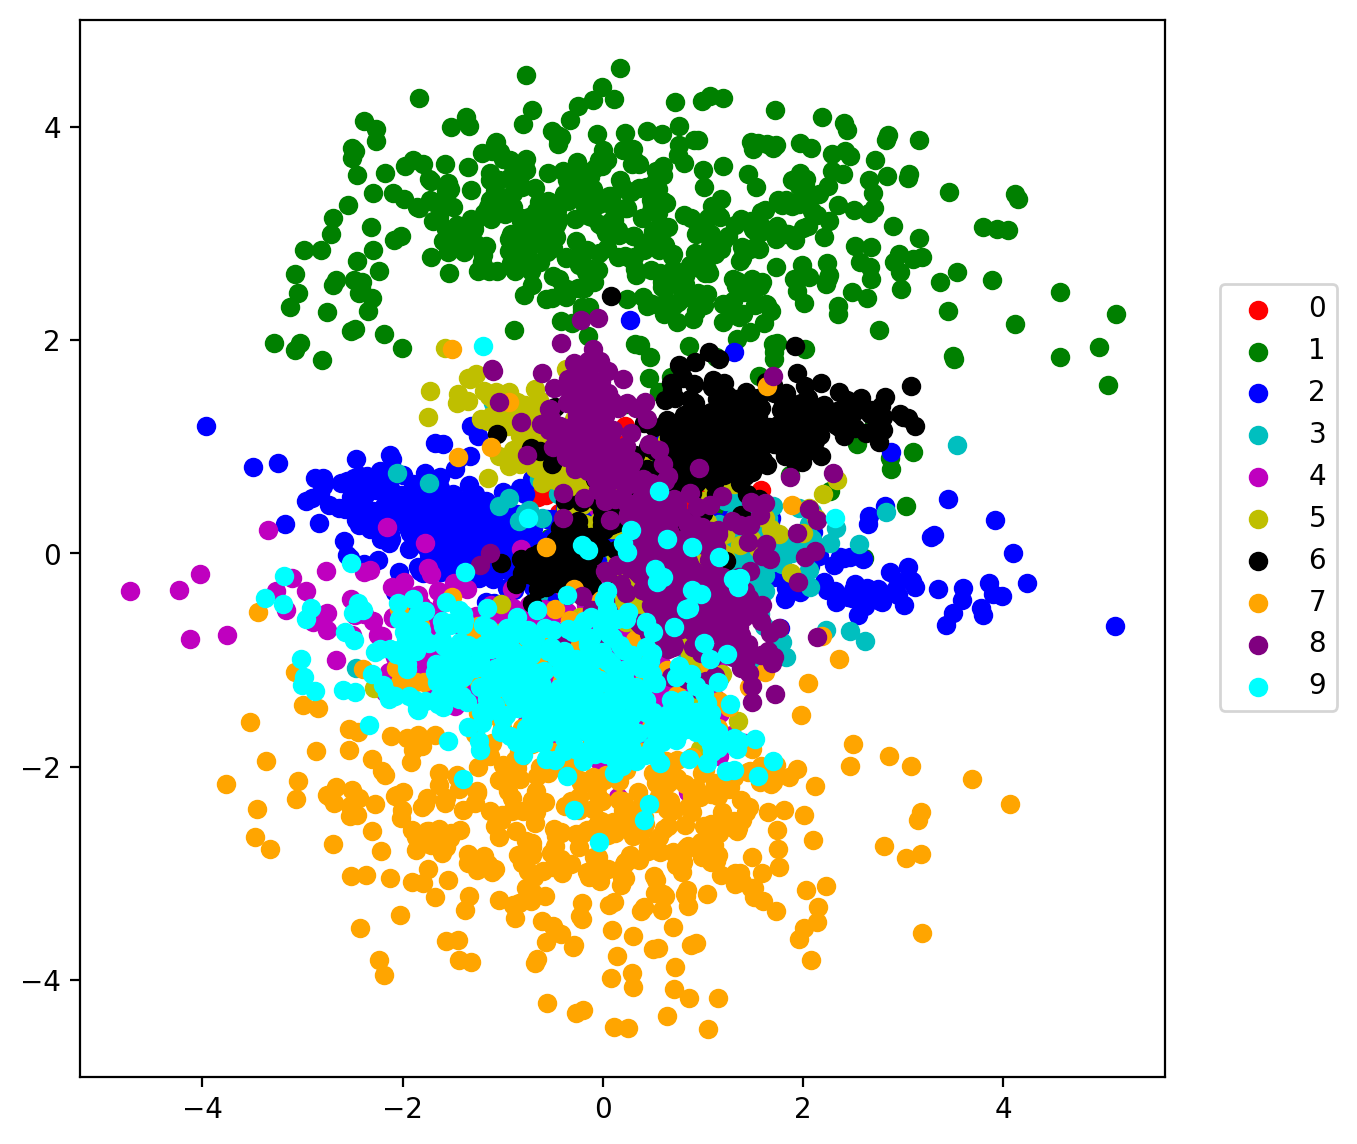

In [12]:
if nz == 2:
    # We can directly plot the embeddings
    plot_embeddings(embeddings, targets)
elif nz > 2:
    tsne_embeddings = TSNE().fit_transform(embeddings)
    plot_embeddings(tsne_embeddings, targets)
else: 
    raise NotImplementedError(f"{nz} not supported")

In [13]:
X, _ = next(iter(val_dataloader))
mu, log_var = trained_model.encoder(X)
Xr = trained_model.decoder(mu).detach()

Let us first take a look at the original images

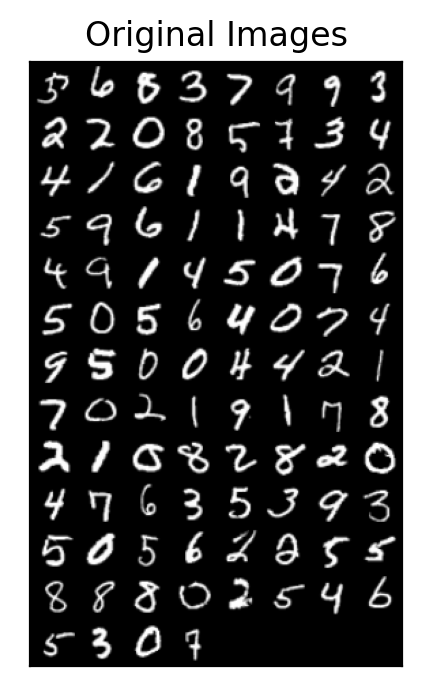

In [14]:
x_grid = torchvision.utils.make_grid(X)
plt.figure(dpi=200)
plt.imshow(x_grid.numpy().transpose((1, 2, 0)))
plt.title("Original Images")
plt.xticks([])
plt.yticks([])
plt.show()

Let us first now take a look at the corresponding reconstructed images

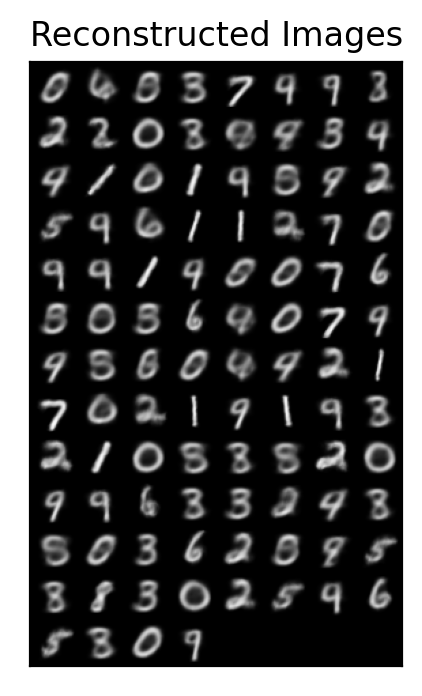

In [15]:
xr_grid = torchvision.utils.make_grid(Xr)
plt.figure(dpi=200)
plt.imshow(xr_grid.numpy().transpose((1, 2, 0)))
plt.title("Reconstructed Images")
plt.xticks([])
plt.yticks([])
plt.show()